# Figure 2a

## Plot omega panels

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
sys.path.append('../../')
from consensus_variables import *

In [3]:
pd.set_option('display.max_columns', None)

# Define gene order and plot and data directories

In [4]:
plots_dir = "plot/fig2bc_omega_all_samples"
data_dir = "data"

In [5]:
def generate_all_side_figures(sample,
                              mut_file,
                              omega_file,
                              gene_list = None,
                              tools = ["omega_trunc", "omega_mis"],
                              plotts = plots_dir,
                              ymaximum = None,
                              between_text = 1.5,
                              withinbartext_off = 1.8,
                              text_off = 0.5,
                              title  = False,
                              legendd = False
                             ):

    snvs_maf = pd.read_table(mut_file, #na_values = custom_na_values
                            )
    snvs_maf = snvs_maf[snvs_maf["TYPE"] == "SNV"].reset_index(drop = True)

    possible_genes = []

    omega_data = pd.read_table(omega_file)
    minimum_pvalue = omega_data[omega_data["pvalue"]>0]["pvalue"].min()
    omega_data = omega_data[omega_data["impact"].isin(['missense', 'truncating'])]
    if "omega_trunc" in tools :
        omega_truncating = omega_data[omega_data["impact"] == "truncating"].reset_index(drop = True)[["gene", "mutations", "dnds", "pvalue", "lower", "upper"]]
        omega_truncating.columns = ["GENE", "mutations_trunc", "omega_trunc", "pvalue", "lower", "upper"]
        omega_truncating_genes = list(pd.unique(omega_truncating["GENE"]))
        possible_genes += omega_truncating_genes

    if "omega_mis" in tools :
        omega_missense = omega_data[omega_data["impact"] == "missense"].reset_index(drop = True)[["gene", "mutations", "dnds", "pvalue", "lower", "upper"]]
        omega_missense.columns = ["GENE", "mutations_mis", "omega_mis", "pvalue", "lower", "upper"]
        omega_missense_genes = list(pd.unique(omega_missense["GENE"]))
        possible_genes += omega_missense_genes

    gene_list = list(set(possible_genes).intersection(set(gene_list)))

    for genee in gene_list:
        print(genee)
        if "omega_trunc" in tools:
            if genee in omega_truncating_genes and genee in omega_missense_genes:
                omega_df = build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense)

                fig_gene_omega = plot_omega_vertical(omega_df, ymaximum,
                                                        between_text = between_text,
                                                        withinbartext_off = withinbartext_off,
                                                        text_off = text_off,
                                                        min_pvalue = minimum_pvalue,
                                                        gene = genee if title else None,
                                                        legenddd = legendd
                                                    )
                fig_gene_omega.savefig(f"{plotts}/{genee}.{sample}.omega_side.png", bbox_inches='tight', dpi = 300)
                plt.show()
                plt.close()


In [6]:
def build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense):

    trunc_omega = float(omega_truncating[omega_truncating["GENE"] == genee]["omega_trunc"].values[0])
    trunc_pvalue = float(omega_truncating[omega_truncating["GENE"] == genee]["pvalue"].values[0])

    miss_omega = float(omega_missense[omega_missense["GENE"] == genee]["omega_mis"].values[0])
    miss_pvalue = float(omega_missense[omega_missense["GENE"] == genee]["pvalue"].values[0])
    snvs_gene = snvs_maf[snvs_maf["canonical_SYMBOL"] == genee].reset_index(drop = True)


    # Calculate counts based on canonical consequences
    truncating_count = float(omega_truncating[omega_truncating["GENE"] == genee]["mutations_trunc"].values[0])
    missense_count = float(omega_missense[omega_missense["GENE"] == genee]["mutations_mis"].values[0])
    synonymous_count = snvs_gene[snvs_gene["canonical_Consequence_broader"].isin(["synonymous"])].shape[0]

    # Compute
    expected_missense = (1 - ((miss_omega - 1) / miss_omega)) * missense_count
    expected_truncating = (1 - ((trunc_omega - 1) / trunc_omega)) * truncating_count


    # Create a dataframe from the counts and expected values
    data = {
        'type': ['truncating', 'synonymous', 'missense'],
        'number_obs': [truncating_count, synonymous_count, missense_count],
        'expected': [expected_truncating, None, expected_missense],
        'omega': [trunc_omega, None, miss_omega],
        'pvalue': [trunc_pvalue, None, miss_pvalue]
    }
    df = pd.DataFrame(data)
    print(df)

    # Print the final dataframe
    return df


In [12]:
def plot_omega_vertical(df,
                        ymax = None,
                        bar_width=0.8,
                        figsize=(4, 5),
                        between_text = 1.5,
                        withinbartext_off = 1.8,
                        text_off = 0.5,
                        min_pvalue = 1e-6,
                        gene = None,
                        legenddd = True
                       ):
    consequence_order = ['truncating', 'missense', 'synonymous',]

    # Define colors
    colors = {
        'truncating': metrics_colors_dictionary["omega_trunc"],
        'missense': metrics_colors_dictionary["omega_miss"],
        'synonymous': metrics_colors_dictionary["omega_synon"]
    }

    # Filter relevant data
    df = df[df['type'].isin(consequence_order)]

    t_obs = df[df['type'] == 'truncating']['number_obs'].item()
    t_omega = df[df['type'] == 'truncating']['omega'].item()
    t_pvalue = df[df['type'] == 'truncating']['pvalue'].item()
    
    m_obs = df[df['type'] == 'missense']['number_obs'].item()
    m_omega = df[df['type'] == 'missense']['omega'].item()
    m_pvalue = df[df['type'] == 'missense']['pvalue'].item()
    
    s_obs = df[df['type'] == 'synonymous']['number_obs'].item()  # Added synonymous mutations

    # Compute x positions for bars
    spacing_factor = bar_width * 1.1  # Adjust spacing based on bar width
    x_positions = np.arange(len(consequence_order)) * spacing_factor

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # **Matplotlib Barplot**
    ax.bar(x_positions,
           [t_obs, m_obs, s_obs], 
           color=[colors[x] for x in consequence_order], 
           width=bar_width,
           edgecolor='none')

    # Overlay expected values as hatched bars (only for truncating & missense)
    for i, row in df.iterrows():
        if row['type'] != 'synonymous':  # No hatch for synonymous
            if legenddd:
                ax.bar(x_positions[consequence_order.index(row['type'])], row['expected'], 
                       color='none', edgecolor="black", hatch='////',
                       linewidth=0,
                       width=bar_width,
                       label = 'expected'
                      )
                legenddd = False
            else:
                ax.bar(x_positions[consequence_order.index(row['type'])], row['expected'], 
                       color='none', edgecolor="black", hatch='////',
                       linewidth=0,
                       width=bar_width
                      )

    # Remove top/right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Customize ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels([])
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)

    ax.spines['left'].set_visible(False)
    ax.set_ylabel('Number of mutations', fontsize = 16 )

    # Positioning text annotations
    between_text_offset = max(max(df['number_obs'].max(), df['expected'].max()) * 0.05, between_text)
    text_offset = max(max(df['number_obs'].max(), df['expected'].max()) * 0.02, text_off)
    within_bar_text_offset = max(max(df['number_obs'].max(), df['expected'].max()) * 0.06, withinbartext_off)

    for i, row in df.iterrows():
        x_pos = x_positions[consequence_order.index(row['type'])]
        y_pos = max(row['number_obs'], row['expected']) + text_offset
        y_pos_low = max(row['number_obs'], row['expected']) - within_bar_text_offset
        omega_value = t_omega if row['type'] == 'truncating' else (m_omega if row['type'] == 'missense' else None)
        p_value = t_pvalue if row['type'] == 'truncating' else (m_pvalue if row['type'] == 'missense' else None)
        color = colors[row['type']]

        # Omega annotation (above the bar) - Only for truncating/missense
        if omega_value is not None:
            excess_mutss = row["number_obs"]*((omega_value-1)/omega_value)
            ax.text(x_pos, y_pos + between_text_offset,
                    # rf'$dN/dS$ = {omega_value:.2f}',
                    rf'dNdS={omega_value:.2f}',
                    fontsize=13, ha='center', va='bottom',
                    # color=color
                    color='black'
                    )

            # P-value annotation (below omega)
            ax.text(x_pos, y_pos,
                    f'$p$<{min_pvalue:.1e}' if p_value < min_pvalue else (f'$p$={p_value:.1e}' if p_value < 0.01 else f'$p$={p_value:.2f}'),
                    fontsize=11, ha='center', va='bottom',
                    # color=color
                    color='black'
                    )

            # Add excess mutations in bar
            if excess_mutss >= 1:
                ax.text(x_pos, y_pos_low,
                        f'{excess_mutss:.0f}',
                        fontsize=13, ha='center', va='bottom', color= 'black')

        else:
            mutations = row['number_obs']
            ax.text(x_pos,
                    y_pos,
                    #y_pos_low,
                    # rf'$dN/dS$ = {omega_value:.2f}',
                    rf'{mutations:.0f}',
                    fontsize=13, ha='center', va='bottom', color='gray')


    plt.legend(frameon=False, bbox_to_anchor = (1,1), fontsize = 13)

    if ymax is not None:
        plt.ylim(0,ymax)

    if gene is not None:
        plt.title(gene, pad = 30, fontsize = 16)

    return fig


all_samples


/tmp/ipykernel_4073876/1099316678.py:15: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  snvs_maf = pd.read_table(mut_file, #na_values = custom_na_values


RBM10
         type  number_obs    expected      omega  pvalue
0  truncating      1983.0   50.813581  39.025000     0.0
1  synonymous       142.0         NaN        NaN     NaN
2    missense       934.0  281.895779   3.313281     0.0


/tmp/ipykernel_4073876/2012801098.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)


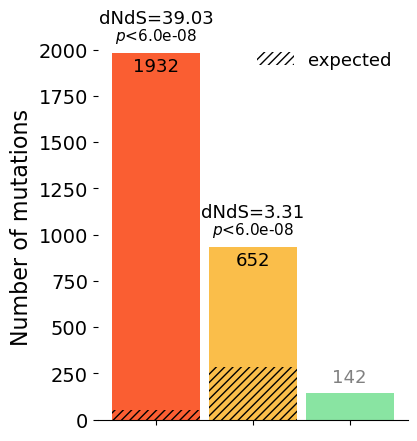

/tmp/ipykernel_4073876/1099316678.py:15: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  snvs_maf = pd.read_table(mut_file, #na_values = custom_na_values
/tmp/ipykernel_4073876/2012801098.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)
/tmp/ipykernel_4073876/2012801098.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, bbox_to_anchor = (1,1), fontsize = 13)


TP53
         type  number_obs    expected     omega  pvalue
0  truncating        68.0   16.683968  4.075769     0.0
1  synonymous        43.0         NaN       NaN     NaN
2    missense       559.0  106.953662  5.226563     0.0


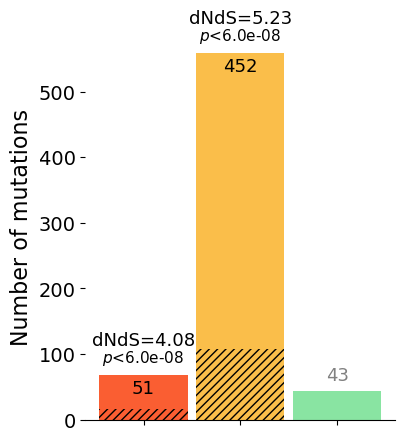

/tmp/ipykernel_4073876/1099316678.py:15: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  snvs_maf = pd.read_table(mut_file, #na_values = custom_na_values
/tmp/ipykernel_4073876/2012801098.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)
/tmp/ipykernel_4073876/2012801098.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, bbox_to_anchor = (1,1), fontsize = 13)


FGFR3
         type  number_obs    expected     omega    pvalue
0  truncating         5.0   16.672094  0.299902  0.001064
1  synonymous        72.0         NaN       NaN       NaN
2    missense       121.0  136.834898  0.884277  0.220399


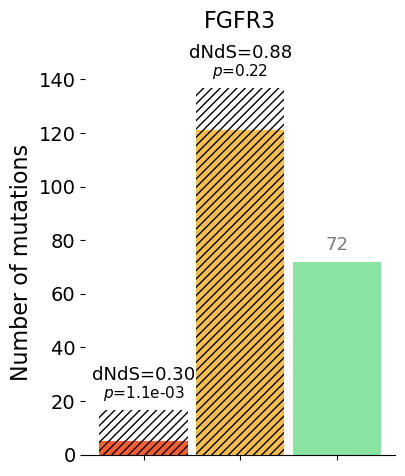

In [13]:
for sampleee in ['all_samples']:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_all_side_figures(sample_name_,
                                mut_filee,
                                omega_filee,
                                ["RBM10"],
                                plotts= plots_dir,
                                title = False,
                                legendd = True
                                )

    generate_all_side_figures(sample_name_,
                                mut_filee,
                                omega_filee,
                                ["TP53"],
                                plotts= plots_dir,
                                title = False,
                                legendd = False
                                )


    generate_all_side_figures(sample_name_,
                                mut_filee,
                                omega_filee,
                                ["FGFR3"],
                                plotts= plots_dir,
                                title = True,
                                legendd = False
                                )



## Plot proportion

In [9]:
def generate_all_side_figures_prop(sample,
                                mut_file,
                                omega_file,
                                gene_list = None,
                                tools = ["omega_trunc", "omega_mis"],
                                plotts = plots_dir,
                                ymaximum = None,
                                between_text = 1.5,
                                withinbartext_off = 1.8,
                                text_off = 0.5,
                                title  = False,
                                legendd = False
                                ):

    snvs_maf = pd.read_table(mut_file, #na_values = custom_na_values
                            )
    snvs_maf = snvs_maf[snvs_maf["TYPE"] == "SNV"].reset_index(drop = True)

    possible_genes = []

    omega_data = pd.read_table(omega_file)
    omega_data = omega_data[omega_data["impact"].isin(['missense', 'truncating'])]
    if "omega_trunc" in tools :
        omega_truncating = omega_data[omega_data["impact"] == "truncating"].reset_index(drop = True)[["gene", "mutations", "dnds", "pvalue", "lower", "upper"]]
        omega_truncating.columns = ["GENE", "mutations_trunc", "omega_trunc", "pvalue", "lower", "upper"]
        omega_truncating_genes = list(pd.unique(omega_truncating["GENE"]))
        possible_genes += omega_truncating_genes

    if "omega_mis" in tools :
        omega_missense = omega_data[omega_data["impact"] == "missense"].reset_index(drop = True)[["gene", "mutations", "dnds", "pvalue", "lower", "upper"]]
        omega_missense.columns = ["GENE", "mutations_mis", "omega_mis", "pvalue", "lower", "upper"]
        omega_missense_genes = list(pd.unique(omega_missense["GENE"]))
        possible_genes += omega_missense_genes


    gene_list = list(set(possible_genes).intersection(set(gene_list)))


    for genee in gene_list:
        print(genee)
        if "omega_trunc" in tools:
            if genee in omega_truncating_genes and genee in omega_missense_genes:
                omega_df = build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense)

                fig_gene_omega = plot_driver_proportion(omega_df,
                                                        legenddd = legendd
                                                        )
                fig_gene_omega.savefig(f"{plotts}/{genee}.{sample}.omega_proportion.png", bbox_inches='tight', dpi = 300)
                plt.show()
                plt.close()


In [ ]:

def plot_driver_proportion(df, 
                           bar_width=0.8,
                           figsize=(2.5, 2.6),
                           min_pvalue=1e-6, 
                           gene=None, 
                           legenddd=True):
    """
    Plot the proportion of driver mutations for truncating and missense mutations.
    
    Args:
        df (pd.DataFrame): Dataframe with columns ['type', 'omega', 'pvalue'].
        bar_width (float, optional): Width of bars.
        figsize (tuple, optional): Figure size.
        min_pvalue (float, optional): Minimum p-value for display.
        gene (str, optional): Gene name for title.
        legenddd (bool, optional): Whether to show legend.
    
    Returns:
        fig: Matplotlib figure object.
    """
    consequence_order = ['truncating', 'missense']
    
    # Define colors
    colors = {
        'truncating': metrics_colors_dictionary["omega_trunc"],
        'missense': metrics_colors_dictionary["omega_miss"]
    }
    
    # Filter relevant data
    df = df[df['type'].isin(consequence_order)]

    # Compute driver proportions
    df['driver_proportion'] = ((df['omega'] - 1) / df['omega']) * 100

    # Compute x positions for bars
    x_positions = np.arange(len(consequence_order)) 

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # **Matplotlib Barplot**
    ax.bar(x_positions, df['driver_proportion'], 
           color=[colors[x] for x in df['type']], 
           width=bar_width, edgecolor='none')

    # Remove top/right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Customize ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels([], fontsize=12)
    plt.ylim(0,100)
    # ax.set_xticklabels(['Truncating', 'Missense'], fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)

    
    ax.spines['left'].set_visible(False)
    ax.set_ylabel('Percentage of drivers', fontsize=14)

    within_bar_text_offset = max(df['driver_proportion'] * 0.13)

    # Add Omega and p-values
    for i, row in df.iterrows():
        x_pos = x_positions[consequence_order.index(row['type'])]
        y_pos = row['driver_proportion'] - within_bar_text_offset


        # Omega annotation (above the bar)
        ax.text(x_pos, y_pos, 
                rf'{row["driver_proportion"]:.0f}%', 
                fontsize=11, ha='center', va='bottom', color='white')

    if gene is not None:
        plt.title(gene, pad=30, fontsize=16)   return fig


all_samples


/tmp/ipykernel_4073876/1260823013.py:15: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  snvs_maf = pd.read_table(mut_file, #na_values = custom_na_values
/tmp/ipykernel_4073876/1260498410.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['driver_proportion'] = ((df['omega'] - 1) / df['omega']) * 100
/tmp/ipykernel_4073876/1260498410.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)


TP53
         type  number_obs    expected     omega  pvalue
0  truncating        68.0   16.683968  4.075769     0.0
1  synonymous        43.0         NaN       NaN     NaN
2    missense       559.0  106.953662  5.226563     0.0


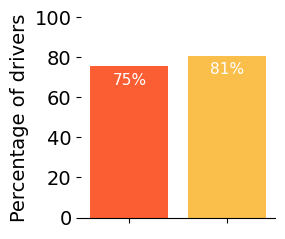

RBM10
         type  number_obs    expected      omega  pvalue
0  truncating      1983.0   50.813581  39.025000     0.0
1  synonymous       142.0         NaN        NaN     NaN
2    missense       934.0  281.895779   3.313281     0.0


/tmp/ipykernel_4073876/1260498410.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['driver_proportion'] = ((df['omega'] - 1) / df['omega']) * 100
/tmp/ipykernel_4073876/1260498410.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)


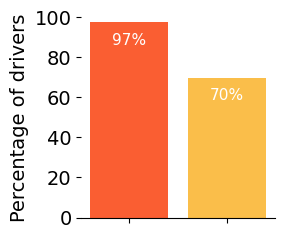

In [11]:
# for sampleee in repeated_samples:
for sampleee in ['all_samples']:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_all_side_figures_prop(sample_name_,
                                mut_filee,
                                omega_filee,
                                ["TP53", "RBM10"],
                                plotts= plots_dir,
                                title = False,
                                legendd = False
                                )

